# Setup 
#* !pip install pytorch-lightning neptune-client --quiet

In [ ]:
#!pip install pytorch-lightning neptune-client --quiet

In [1]:
import torch
import pytorch_lightning as pl

print(f"PyTorch version: {torch.__version__}")
print(f"Pytorch Lightning version: {pl.__version__}")

PyTorch version: 1.8.2+cu111
Pytorch Lightning version: 1.5.6


In [2]:
import os
import glob
# import imageio
import random
import subprocess
import numpy as np
import pandas as pd
import nibabel as nib
from argparse import Namespace
import matplotlib.pyplot as plt

from dataset_mri_3D import DatasetMRI
from data_module_3D import MRICCDataModule # Transformadas (Data Augmentation) e # Datamodule 

from dice_score import dice_coeff # Implementação do Dice
#from unet_model_3D.lightningMRICC3D import LightningMRICC # Lightning Module

#from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger


#from prediction import Prediction

In [3]:
#path_Data = "/content/drive/MyDrive/Unicamp-Mestrado/MRI_Data/MRI_npz/"
path_Data = "../.."
DATASET_NAME = "Brain_projeto_IA901A"

In [4]:
# DEBUG
# Tentar carregar todos os exemplos dos dois datasets
from tqdm import tqdm
for mode in ["train", "val"]:
    for sample in tqdm(DatasetMRI(mode, os.path.join(path_Data, DATASET_NAME)), leave=True, position=0, desc="Load testing..."):
        pass

Tamanho do Datset: 1
train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: None


Load testing...: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Tamanho do Datset: 1
val DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: None


Load testing...: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Tamanho do Datset: 1
train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: None
float32
(1, 256, 256, 192) (1, 256, 256, 192)


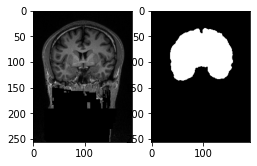

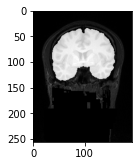

In [5]:
n_slice = 128
sample = random.choice(DatasetMRI(random.choice(["train"]), os.path.join(path_Data, DATASET_NAME)))
image, seg = sample["image"], sample["seg_image"]
print(seg.dtype)
print(image.shape,seg.shape)
plt.subplot(1, 3, 1)
plt.imshow(image[0,n_slice,:,:].squeeze(), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(seg[0,n_slice,:,:].squeeze(), cmap="gray")
plt.show()
plt.subplot(1, 3, 3)
plt.imshow((image[0,n_slice,:,:].squeeze()+seg[0,n_slice,:,:].squeeze())/2, cmap="gray")
plt.show()
#print(image)




In [6]:
#n_slice = 85
#sample = random.choice(DatasetMRI(random.choice(["train"]), os.path.join(path_Data, "dados_teste_3D")))
#image, seg = sample["image"], sample["seg_image"]
#print(seg.dtype)
#print(image[0].shape,image[1].shape,image[2].shape,seg.shape)
#plt.subplot(1, 4, 1)
#plt.imshow(image[0][n_slice,:,:].squeeze(), cmap="gray")
#plt.subplot(1, 4, 2)
#plt.imshow(image[1][n_slice,:,:].squeeze(), cmap="gray")
#plt.subplot(1, 4, 3)
#plt.imshow(image[2][n_slice,:,:].squeeze(), cmap="gray")
#plt.subplot(1, 4, 4)
#plt.imshow(seg[0,n_slice,:,:].squeeze(), cmap="gray")
#plt.show()

# Hiperparâmetros

In [7]:
hyperparameters = {"experiment_name": "ExperimentV2_ManualMask_HC_bt_2x5",
                   "data_folder": os.path.join(path_Data, DATASET_NAME),
                   "train_transform_str": "RandomCrop", #RandomCrop
                   "eval_transform_str": "RandomCrop",
                   "max_epochs": 700,
                   "batch_size": 2,
                   "acum": 5,
                   "nworkers": 8,
                   "snout": 1, # número de canais de saídas da rede de segmentação
                   "nin": 1, # número de canais de entrada
                   "lr": 0.0001, 
                   "manual_seed": 4321,
                   "description": "First experiments for CC segmentation to the dissertation.",
                   "cpu": False,
                  }
hparams = Namespace(**hyperparameters)

for k, v in vars(hparams).items():
    print(f"{k}: {v}")

experiment_name: ExperimentV2_ManualMask_HC_bt_2x5
data_folder: ../../Brain_projeto_IA901A
train_transform_str: RandomCrop
eval_transform_str: RandomCrop
max_epochs: 700
batch_size: 2
acum: 5
nworkers: 8
snout: 1
nin: 1
lr: 0.0001
manual_seed: 4321
description: First experiments for CC segmentation to the dissertation.
cpu: False


Tamanho do Datset: 1
train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: ReturnPatch: ppositive None, patch_size (80, 80, 80), kernel_shape (3, 3), volumetric True, anyborder True, fullrandom True, segmentation True, reset_seed False
Tamanho do Datset: 1
val DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: ReturnPatch: ppositive None, patch_size (80, 80, 80), kernel_shape (3, 3), volumetric True, anyborder True, fullrandom True, segmentation True, reset_seed False
torch.Size([1, 1, 80, 80, 80]) torch.Size([1, 1, 80, 80, 80])


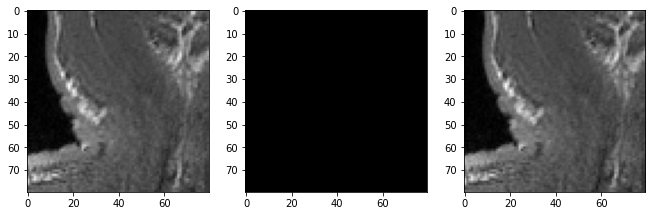

In [8]:
# DEBUG DATA MODULE
from torchvision.utils import make_grid
data_module = MRICCDataModule(Namespace(**hyperparameters))
data_module.setup()

dataloader = data_module.train_dataloader()
sample = next(iter(dataloader))

img_batch = sample["image"]
seg_batch = sample["seg_image"]
print(img_batch.shape, seg_batch.shape)
#if hyperparameters["train_transform_str"] == FiveCrop3D:
#    bs, ncrops, c, h, w = img_batch.size()
#    img_batch = img_batch.view(-1, c, h, w)
#    seg_batch = seg_batch.view(-1, c, h, w)

n_slice = 44
img_batch = img_batch[:,:,n_slice,:,:]
seg_batch = seg_batch[:,:,n_slice,:,:]
#print(img_batch.shape, seg_batch.shape)

img_grid = make_grid(img_batch, normalize=True)
seg_grid = make_grid(seg_batch, normalize=True)

if hyperparameters["data_folder"] == f"../../{DATASET_NAME}":   #.permute(1, 2, 0).numpy()

    #print('dados_teste_3D') 
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 4, 1)
    plt.imshow(img_grid[0].numpy(), cmap='gray')
    plt.subplot(1, 4, 2)
    plt.imshow(seg_grid[0].numpy(), cmap='gray')
    plt.subplot(1, 4, 3)
    plt.imshow((img_grid[0].numpy()+seg_grid[0].numpy())/2, cmap='gray')
    plt.show()  

# Treino
Agora vamos usar o Trainer do PL.

* Checkpoint: Salvar o LightningModule, para permitir re-uso sem treinar do zero.

* Logger: Interface com Neptune.

In [9]:
# Passe sua API KEY do Neptune
from getpass import getpass
# api_key = getpass()

api_key = os.getenv("NEPTUNE_API_TOKEN")
#api_key = ""
assert api_key is not None

AssertionError: 

In [ ]:
#ckpt_salve_path = "/content/drive/MyDrive/Unicamp-Mestrado/MRI_Data/"

### First Training model

In [10]:
debug = True
from unet_module import LightningMRICCv2 # Lightning Module
from pytorch_lightning.callbacks import TQDMProgressBar
# Inicialização do LightningModule
model = LightningMRICCv2(hparams)
data = MRICCDataModule(hparams)

# Onde salvar checkpoints
ckpt_path = "../logs"
os.makedirs(ckpt_path, exist_ok=True)  

# Recomenda-se não inicializar o logger se estiver fazendo debug
if debug:
    neptune_logger = None
    checkpoint_callback = None
else:
    # Objeto do logger, neste caso o Neptune. 
    # A API Key deve ser secreta e você consegue criando uma conta no Neptune.

    neptune_logger = NeptuneLogger(
        api_key=api_key,
        name=hyperparameters["experiment_name"],
        project="jrodrigues/dissegcc",
    )

#    neptune_logger = NeptuneLogger(
#        api_key=api_key,
#        #project_name="dscarmo/sandbox",
#        project_name="jrodrigues/dissegcc",
#        experiment_name=hyperparameters["experiment_name"],
#        params=hyperparameters)
    #

    # Configuração do Checkpoint
    checkpoint_callback = [ModelCheckpoint(dirpath=ckpt_path,  # path onde será salvo o checkpoint
                                           filename=hyperparameters["experiment_name"] + "{epoch}-{val_loss:.2f}",
                                           monitor="val_loss",  
                                           mode="min")]#,
                          #TQDMProgressBar(refresh_rate=0),
                           # EarlyStopping(monitor="val_loss",
                           #               mode="min",
                           #               patience = 15, verbose=True)]
    # Importante prestar atenção nas opções do ModelCheckpoint para não acabar dando overwrite em pesos antigos sem querer!
    #

trainer = pl.Trainer(max_epochs=hyperparameters["max_epochs"],
                     gpus=0 if hyperparameters["cpu"] else 1,
                     fast_dev_run=debug,
                     logger=neptune_logger,  
                     callbacks=checkpoint_callback,
                     accumulate_grad_batches=hyperparameters["acum"]
                     )

print("Hyperparameters:\n")
for k, v in hyperparameters.items():
    print(f'{k}: {v}')

trainer.fit(model, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


UNet in channels: 1 batch_norm: instance dim: 3d out_channels 1 
Hyperparameters:

experiment_name: ExperimentV2_ManualMask_HC_bt_2x5
data_folder: ../../Brain_projeto_IA901A
train_transform_str: RandomCrop
eval_transform_str: RandomCrop
max_epochs: 700
batch_size: 2
acum: 5
nworkers: 8
snout: 1
nin: 1
lr: 0.0001
manual_seed: 4321
description: First experiments for CC segmentation to the dissertation.
cpu: False
Tamanho do Datset: 1
train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: ReturnPatch: ppositive None, patch_size (80, 80, 80), kernel_shape (3, 3), volumetric True, anyborder True, fullrandom True, segmentation True, reset_seed False
Tamanho do Datset: 1
val DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A. Transforms: ReturnPatch: ppositive None, patch_size (80, 80, 80), kernel_shape (3, 3), volumetric True, anyborder True, fullrandom True, segmentation True, reset_seed False



  | Name  | Type | Params
-------------------------------
0 | model | UNet | 2.6 M 
-------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.289    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.607, val_loss=0.608, val_dice=0.426]
